In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import numpy as np
import itertools

print(os.getcwd())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

df_train = pd.read_csv("../codeT5/train_data.csv")
df_test = pd.read_csv("../codeT5/test_data.csv")

X_train = torch.load("../codeT5/X_train.pt", weights_only=False)
X_test = torch.load("../codeT5/X_test.pt", weights_only=False)

def process_vulnerability_list(vuln_list_series, num_classes=9):
    vuln_lists = vuln_list_series.apply(ast.literal_eval)  
    y_binary = np.array([np.array(vuln) for vuln in vuln_lists], dtype=np.float32)
    if y_binary.shape[1] != num_classes:
        raise ValueError(f"Expected {num_classes} dimensions, got {y_binary.shape[1]}")
    return torch.tensor(y_binary, dtype=torch.float32)

y_train = process_vulnerability_list(df_train['vulnerability_list'], num_classes=9)
y_test = process_vulnerability_list(df_test['vulnerability_list'], num_classes=9)

torch.save(y_train, "../codeT5/y_train.pt")
torch.save(y_test, "../codeT5/y_test.pt")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

/Users/rita/Documents/9309_ML/Smart_Contract_Vulnerabilities_Project/Model Training
Training on device: mps
X_train shape: torch.Size([4294, 768])
y_train shape: torch.Size([4294, 9])
X_test shape: torch.Size([1074, 768])
y_test shape: torch.Size([1074, 9])


In [ ]:
class VulnScreener(nn.Module):
    def __init__(self):
        super(VulnScreener, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(768, 256), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  
            nn.Sigmoid()         
        )
    
    def forward(self, x):
        return self.mlp(x)  

screener = torch.load('../codeT5/vuln_screener_model.pth', weights_only=False)
screener.to(device)
screener.eval()
with torch.no_grad():
    train_prob = screener(X_train.to(device))
    test_prob = screener(X_test.to(device))

def oversample_rare_classes(X, p_s, y, class_indices=[2, 3, 7], multiplier=3):
    mask = torch.any(y[:, class_indices] == 1, dim=1)
    X_rare = X[mask]
    p_s_rare = p_s[mask]
    y_rare = y[mask]
    X = torch.cat([X] + [X_rare] * multiplier, dim=0)
    p_s = torch.cat([p_s] + [p_s_rare] * multiplier, dim=0)
    y = torch.cat([y] + [y_rare] * multiplier, dim=0)
    return X, p_s, y

X_train, train_prob, y_train = oversample_rare_classes(X_train, train_prob, y_train)

In [ ]:
class VulnAnalyzer(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(VulnAnalyzer, self).__init__()
        self.embedding = nn.Linear(769, 768)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=768,
                nhead=8,
                dim_feedforward=1024,
                dropout=dropout_rate,
                batch_first=True
            ),
            num_layers=3
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(768, 9)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, p_s):
        if p_s.dim() == 1:
            p_s = p_s.unsqueeze(1)
        x = torch.cat((x, p_s), dim=1)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        transformer_out = self.transformer(x)
        attn_weights = self.transformer.layers[-1].self_attn(x, x, x)[1]
        x = transformer_out.squeeze(1)
        x = self.dropout(x)
        z = self.fc(x)
        p_a = self.sigmoid(z)
        return p_a, attn_weights

def train_vuln_analyzer(X_train, p_s_train, y_train, threshold=0.7, epochs=200, lr=0.0005, dropout_rate=0.1, weight_decay=0.01, validator_feedback=None):
    model = VulnAnalyzer(dropout_rate=dropout_rate).to(device)
    
    class_counts = y_train.sum(dim=0)
    total_samples = y_train.shape[0]
    class_weights = total_samples / (9 * class_counts + 1e-6)
    criterion = nn.BCELoss(weight=class_weights.to(device))
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
    
    X_train, p_s_train, y_train = X_train.to(device), p_s_train.to(device), y_train.to(device)
    
    best_f1 = 0.0
    current_threshold = threshold
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        mask = p_s_train > current_threshold
        X_train_filtered = X_train[mask.squeeze()]
        p_s_train_filtered = p_s_train[mask]
        y_train_filtered = y_train[mask.squeeze()]
        
        if len(X_train_filtered) == 0:
            current_threshold = max(0.1, current_threshold - 0.1)
            mask = p_s_train > current_threshold
            X_train_filtered = X_train[mask.squeeze()]
            p_s_train_filtered = p_s_train[mask]
            y_train_filtered = y_train[mask.squeeze()]
        
        p_a, attn_weights = model(X_train_filtered, p_s_train_filtered)
        loss = criterion(p_a, y_train_filtered)
        
        with torch.no_grad():
            y_pred_binary = (p_a > 0.5).float()
            correct = (y_pred_binary == y_train_filtered).float().sum()
            total = y_train_filtered.numel()
            train_acc = correct / total
            
            precision = precision_score(y_train_filtered.cpu(), y_pred_binary.cpu(), average='micro', zero_division=0)
            recall = recall_score(y_train_filtered.cpu(), y_pred_binary.cpu(), average='micro')
            f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            
            if f1 > best_f1 and recall > 0.7:
                best_f1 = f1
                current_threshold = min(0.95, current_threshold + 0.05)
            elif f1 < best_f1 * 0.9:
                current_threshold = max(0.1, current_threshold - 0.05)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        scheduler.step(loss)
        
        if validator_feedback is not None and epoch % 10 == 0 and epoch > 0:
            with torch.no_grad():
                for vuln_idx, correction_factor in validator_feedback.items():
                    if vuln_idx < 9 and correction_factor > 0:
                        model.fc.weight[vuln_idx] *= (1 + correction_factor * 0.1)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Train Acc: {train_acc.item():.4f}, Train F1: {f1:.4f}, Threshold: {current_threshold:.3f}")
    
    return model

def test_vuln_analyzer(model, X_test, p_s_test, y_test, detailed_report=True):
    model.eval()
    X_test, p_s_test, y_test = X_test.to(device), p_s_test.to(device), y_test.to(device)
    
    with torch.no_grad():
        p_a, attn_weights = model(X_test, p_s_test)
        y_pred_proba = p_a.cpu().numpy()
        y_true = y_test.cpu().numpy()
    
    metrics = {}
    n_classes = y_true.shape[1]
    optimal_thresholds = []
    
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        valid_idx = np.where(recall[:-1] >= 0.7)[0]
        optimal_threshold = thresholds[valid_idx[np.argmax(precision[valid_idx])]] if len(valid_idx) > 0 else 0.5
        optimal_thresholds.append(optimal_threshold)
        plt.plot(recall, precision, label=f'Class {i} (Opt. Threshold: {optimal_threshold:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        auc_score = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC: {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    y_pred_binary = np.zeros_like(y_pred_proba)
    for i in range(n_classes):
        y_pred_binary[:, i] = (y_pred_proba[:, i] >= optimal_thresholds[i]).astype(int)
    
    metrics['avg_precision'] = precision_score(y_true, y_pred_binary, average='micro')
    metrics['avg_recall'] = recall_score(y_true, y_pred_binary, average='micro')
    metrics['avg_f1'] = f1_score(y_true, y_pred_binary, average='micro')
    metrics['avg_auc'] = roc_auc_score(y_true, y_pred_proba, average='micro')
    metrics['optimal_thresholds'] = optimal_thresholds
    
    class_metrics = {
        'precision': precision_score(y_true, y_pred_binary, average=None),
        'recall': recall_score(y_true, y_pred_binary, average=None),
        'f1': f1_score(y_true, y_pred_binary, average=None),
        'auc': [roc_auc_score(y_true[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    }
    metrics['class_metrics'] = class_metrics
    
    plt.figure(figsize=(15, 15))
    for i in range(n_classes):
        cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
        plt.subplot(3, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Class {i} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    print("\n=== VulnAnalyzer Test Results (Optimal Thresholds) ===")
    print(f"Test Samples: {len(X_test)}")
    print(f"Average Precision: {metrics['avg_precision']:.4f}")
    print(f"Average Recall: {metrics['avg_recall']:.4f}")
    print(f"Average F1-Score: {metrics['avg_f1']:.4f}")
    print(f"Average AUC: {metrics['avg_auc']:.4f}")
    
    if detailed_report:
        print("\nPer-Class Metrics with Optimal Thresholds:")
        for i in range(n_classes):
            print(f"\nVulnerability {i} (Threshold: {optimal_thresholds[i]:.3f}):")
            print(f"Precision: {class_metrics['precision'][i]:.4f}")
            print(f"Recall: {class_metrics['recall'][i]:.4f}")
            print(f"F1-Score: {class_metrics['f1'][i]:.4f}")
            print(f"AUC: {class_metrics['auc'][i]:.4f}")
    
    return metrics, y_pred_proba, attn_weights

def hyperparameter_tuning(X_train, p_s_train, y_train, X_test, p_s_test, y_test):
    param_grid = {
        'lr': [0.0001, 0.0005, 0.001],
        'dropout_rate': [0.1, 0.2, 0.3],
        'weight_decay': [0.001, 0.01, 0.1]
    }
    
    best_f1 = 0.0
    best_params = None
    best_model = None
    
    for lr, dropout_rate, weight_decay in itertools.product(param_grid['lr'], param_grid['dropout_rate'], param_grid['weight_decay']):
        print(f"\nTuning with lr={lr}, dropout_rate={dropout_rate}, weight_decay={weight_decay}")
        model = train_vuln_analyzer(
            X_train, p_s_train, y_train,
            threshold=0.7, epochs=50, lr=lr, dropout_rate=dropout_rate, weight_decay=weight_decay,
            validator_feedback={0: 0.5, 2: 0.3}
        )
        
        metrics, _, _ = test_vuln_analyzer(model, X_test, p_s_test, y_test, detailed_report=False)
        f1 = metrics['avg_f1']
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'lr': lr, 'dropout_rate': dropout_rate, 'weight_decay': weight_decay}
            best_model = model
            print(f"New best F1: {best_f1:.4f} with params {best_params}")
    
    return best_model, best_params

Epoch 0, Loss: 0.8744, Train Acc: 0.6137, Train F1: 0.2968, Threshold: 0.700
Epoch 10, Loss: 0.4417, Train Acc: 0.8551, Train F1: 0.3666, Threshold: 0.700
Epoch 20, Loss: 0.4135, Train Acc: 0.8626, Train F1: 0.4090, Threshold: 0.700
Epoch 30, Loss: 0.3765, Train Acc: 0.8763, Train F1: 0.4606, Threshold: 0.700
Epoch 40, Loss: 0.3306, Train Acc: 0.8890, Train F1: 0.5403, Threshold: 0.700
Epoch 50, Loss: 0.3103, Train Acc: 0.8989, Train F1: 0.5930, Threshold: 0.700
Epoch 60, Loss: 0.2933, Train Acc: 0.9025, Train F1: 0.6190, Threshold: 0.700
Epoch 70, Loss: 0.2723, Train Acc: 0.9079, Train F1: 0.6605, Threshold: 0.700
Epoch 80, Loss: 0.2512, Train Acc: 0.9102, Train F1: 0.6786, Threshold: 0.700
Epoch 90, Loss: 0.2409, Train Acc: 0.9215, Train F1: 0.7066, Threshold: 0.700
Epoch 100, Loss: 0.2276, Train Acc: 0.9230, Train F1: 0.7111, Threshold: 0.700
Epoch 110, Loss: 0.2025, Train Acc: 0.9317, Train F1: 0.7503, Threshold: 0.700
Epoch 120, Loss: 0.1924, Train Acc: 0.9334, Train F1: 0.7578, T

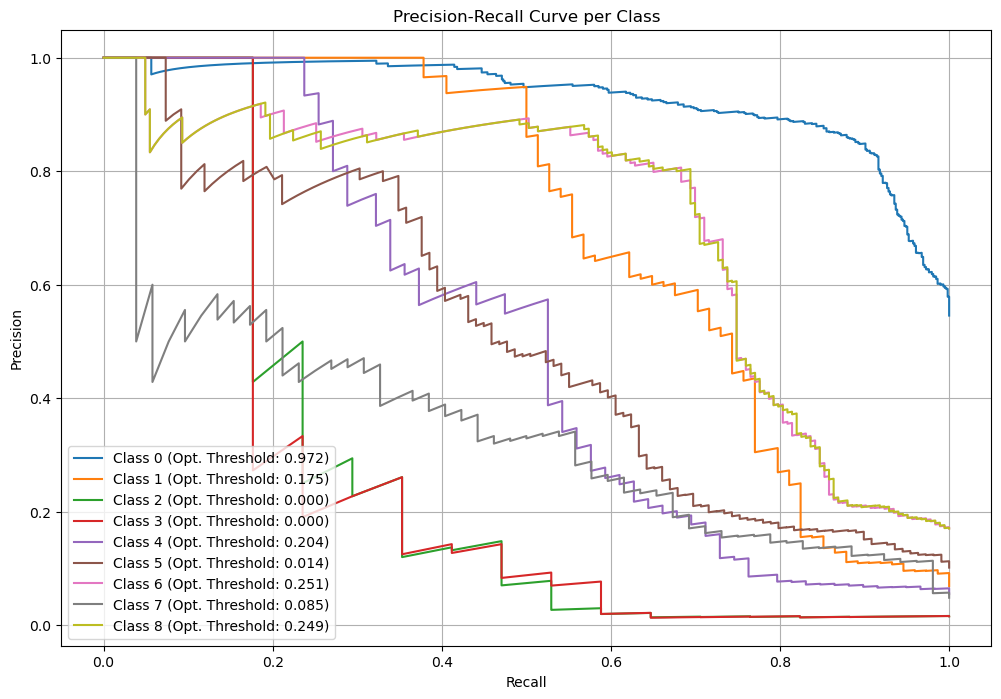

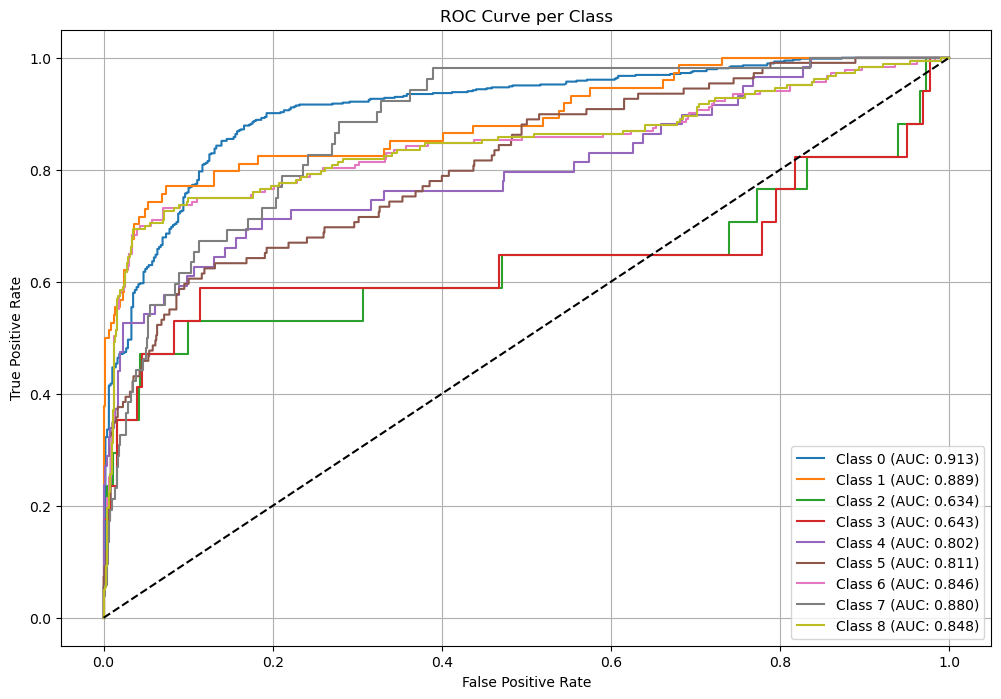

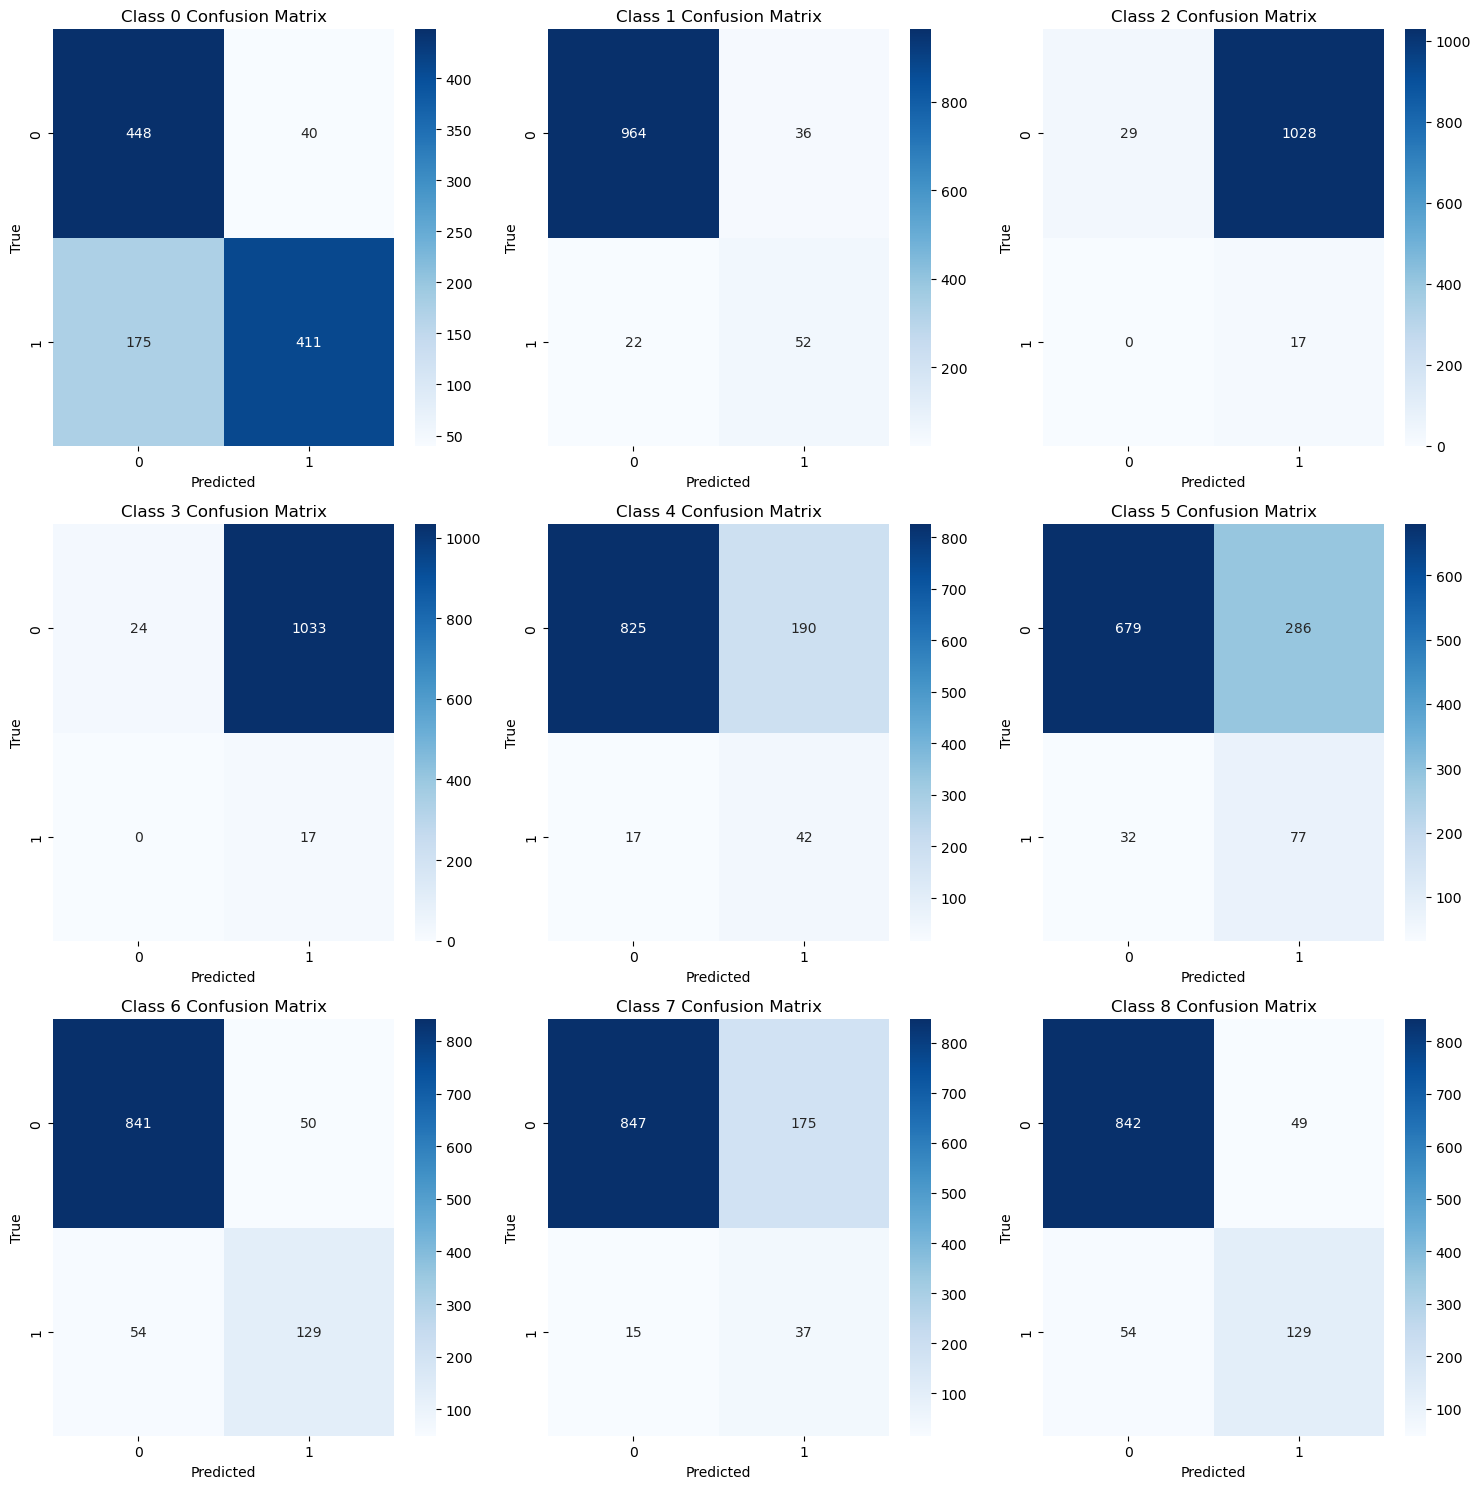


=== VulnAnalyzer Test Results (Optimal Thresholds) ===
Test Samples: 1074
Average Precision: 0.2399
Average Recall: 0.7117
Average F1-Score: 0.3588
Average AUC: 0.8880

Per-Class Metrics with Optimal Thresholds:

Vulnerability 0 (Threshold: 0.972):
Precision: 0.9113
Recall: 0.7014
F1-Score: 0.7927
AUC: 0.9126

Vulnerability 1 (Threshold: 0.175):
Precision: 0.5909
Recall: 0.7027
F1-Score: 0.6420
AUC: 0.8886

Vulnerability 2 (Threshold: 0.000):
Precision: 0.0163
Recall: 1.0000
F1-Score: 0.0320
AUC: 0.6343

Vulnerability 3 (Threshold: 0.000):
Precision: 0.0162
Recall: 1.0000
F1-Score: 0.0319
AUC: 0.6426

Vulnerability 4 (Threshold: 0.204):
Precision: 0.1810
Recall: 0.7119
F1-Score: 0.2887
AUC: 0.8017

Vulnerability 5 (Threshold: 0.014):
Precision: 0.2121
Recall: 0.7064
F1-Score: 0.3263
AUC: 0.8115

Vulnerability 6 (Threshold: 0.251):
Precision: 0.7207
Recall: 0.7049
F1-Score: 0.7127
AUC: 0.8463

Vulnerability 7 (Threshold: 0.085):
Precision: 0.1745
Recall: 0.7115
F1-Score: 0.2803
AUC: 0.

In [ ]:
validator_feedback = {0: 0.5, 2: 0.3}
#best_model, best_params = hyperparameter_tuning(X_train, train_prob, y_train, X_test, test_prob, y_test)
#print(f"\nBest Hyperparameters: {best_params}")

final_model = train_vuln_analyzer(
    X_train, train_prob, y_train,
    threshold=0.7, epochs=200,
    lr=0.0001, dropout_rate=0.1, weight_decay=0.01,
    validator_feedback={0: 0.5, 2: 0.3}
)
metrics, probabilities, attn_weights = test_vuln_analyzer(final_model, X_test, test_prob, y_test)

print("\nSample Probabilities (first 5):", probabilities[:5])
print("Attention Weights Shape:", attn_weights.shape)